## Intro


KARL MAKE SURE TO UPDATE AND REFERENCE 

### Goal:
An MNIST image is 784 pixels when unravelled. It is B/W, with values from 0-255. I want to create a ML model which will recognise the number written in the image.

### To Investigate:
How changing the number of hidden layer nodes affects the output. 

How adding layers or changing the nonlinear relationship (activation fn) between the layers affects the output. tanh, sigmoid, relu

Graphing how quickly the model learns and reaches a threshold. 

How to squeeze a very accurate model out of it, maybe combine them? 

something with the back prop?

how does the alpha affect it? 

instead of iterations, until an accuracy is reached? 

should I add some randomness to try find a global min?

trying a different descent - with momentum? 

trying He initialization (typically used for ReLU activation functions) or Xavier

Cross entropy loss?

### How it works
Need to transpose first for Matrix Multiplication
#### Forward Propagation
This is how an image will proceed through the network

A[0] = input layer (784 nodes)

A[1] = ReLU( w[1]*A[0]+b[1] ), ReLU is the activation fn, it makes it a nonlinear relationship, RELU is f(x) = x, x>0, =0 x<=0. w is weights and b is biases. (10 nodes)

A[2] = g(w[2]*A[1] +b[2]), g is softmax as this goes to the output layer. softmax is essentially exp() / sum(exp()). gives a probability. (10 nodes, 0-1 probability of being the value 0-9)

#### Backward Propagation
The thing that makes it learn. Want to see how wrong the model was and adjust the weights and biases

what I want to know is how we know how much to change the weights by? 

this is the part I least understand

obviously you have to do it in reverse - so the transpose of the matrix and the differential of the activation fn. 

dz[2] = A[2] - Y, Y is the answer from the catalogue

unsure about this...

dw[2] = 1/m dz[2]* a[1]^T, derivative of the loss fn wrt the weights, m is no of columns (ie number of images as it's been transposed)

db[2] = 1/m sum dz[2], average of the absolute error 

dz[1] = w[2]^T * dz[2] * g'(z[1]), 1st derivative of activation fn 

dw[1] = 1/m dz[1] * A[0]^T

db[1] = 1/m sum(dz[1])

#### Update parameters
need to choose \alpha, learning rate hyperparameterm

for each parameter (eg w[2]) you remove the delta times learning rate (-\alpha* dw[2])

# Code

#### Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

#get data
data = pd.read_csv('train.csv')
data = np.array(data) #convert to numpy array 

m,n = data.shape #rows and columns m&n
np.random.shuffle(data) #shuffle

data = data.T #transpose 

labels = data[0] 
X = data[1:]/255 #these will be the imputs, /255 to normalise

data is now nxm, ie 785 x 42000 array. the extra row is the label of 0-9

#### Generate functions

In [8]:
def RELU(a):
    """
    Performs the ReLU function, if the value is above zero it is returned, if it is below zero, zero is returned
    """
    return np.maximum(a,0)

def softmax(a):
    """
    Performs softmax, essentially will get a probability out
    """
    ####Not sure about this one 
#     return np.exp(a) / (np.sum(np.exp(a),axis=0)) ###changed back to np.sum
    a = a - np.max(a, axis=0, keepdims=True)  # Stability improvement
    return np.exp(a) / np.sum(np.exp(a), axis=0, keepdims=True)

def RELU_prime(a):
    """
    The derivative of the RELU fn. Returns 1 if x>0, 0 if x<=0
    """
  
    
    return a>0 



def initialise():
    """
    Randomly initialises the weights and biases using a normal distribution
    """
    w1 = np.random.normal(size = (10, 784))
    b1 = np.random.normal(size = (10, 1))
    w2 = np.random.normal(size = (10, 10))
    b2 = np.random.normal(size = (10, 1))
    
    return w1,b1,w2,b2


def forwardprop(w1,b1, w2,b2, x):
    """
    Forward propagates the image through the net
    """
    z1 = w1.dot(x) + b1 #apply weights and biases
    a1 = RELU(z1) #activate layer
    
    z2 = w2.dot(a1) + b2 #apply w&b for 2nd layer
    a2 = softmax(z2) #activate for output layer
    
    return z1,a1,z2,a2

def fix(y):
    #called one-hotting? (dk what that means)
    Y = np.zeros((y.size, y.max() + 1))
    Y[np.arange(y.size), y] = 1
    return Y.T

def backprop(z1,a1, z2,a2, w1,w2, x,y): #y is labels 
    global m 
    #need to get y in a nice format before putting it in here
    y = fix(y)
    
    dz2 = a2 - y
    dw2 = 1/m * dz2.dot(a1.T)
    db2 = 1/m * np.sum(dz2,1,keepdims=True)
#     print('backpropworkings: dz2,db2')
#     print(dz2.shape)
# #     print(dw2.shape)
#     print(db2.shape)
    
#     print(dz2)
#     print(dw2)
#     print(db2)
#     print('np.sum')
#     print(np.sum(dz2))
#     print('1/m * np.sum')
#     print(1/m * np.sum(dz2,1))
#     print('sum')
#     print(sum(dz2).shape)
    
    
    dz1 = (w2.T).dot(dz2) * RELU_prime(z1)
    dw1 = 1/m * dz1.dot(x.T)
    db1 = 1/m * np.sum(dz1,1, keepdims=True)
    
    return dw1, db1,dw2,db2

def update(w1,b1, w2,b2, dw1,db1, dw2,db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1,b1, w2,b2
        
def accuracy(prediction,y):
    if y.ndim > 1:  #Make sure it's not one hotted
        y = np.argmax(y, axis=0)
    return np.sum(prediction==y)/y.size

# def accuracy(prediction,y):
#     for Y in range(len(y)):
# #         if Y.ndim > 1:  #Make sure it's not one hotted
# #             Y = np.argmax(y, axis=0)
#         return np.sum(prediction==Y)/y.size
##NEVERMIND


In [9]:
def LEARN(x,y, iterations, alpha=0.7):
    w1,b1,w2,b2 = initialise()
#     print('init w1b1')
#     print(w1.shape,b1.shape,w2.shape,b2.shape)
    
    for i in range(iterations):
        z1,a1,z2,a2 = forwardprop(w1,b1,w2,b2, x)
#         print('forward, z1,a1,z2,a2')
#         print(z1.shape,a1.shape,z2.shape,a2.shape)
        
        dw1,db1, dw2,db2 = backprop(z1,a1, z2,a2, w1,w2, x,y)
#         print('backward,dw1,db1, dw2,db2')
#         print(dw1.shape,db1.shape, dw2.shape,db2.shape)
        
        w1,b1, w2,b2 = update(w1,b1, w2,b2, dw1,db1, dw2,db2, alpha)
        
        if i % 50 ==0:
            print(i)
#             print('a2', a2.shape)
            prediction = np.argmax(a2,axis=0)
            print(prediction.shape)
            print(prediction)
#             print("pred",prediction.shape)
#             print(prediction>0)
            print("accuracy",accuracy(prediction,y))
    return w1,b1,w2,b2

In [10]:
w1,b1,w2,b2 = LEARN(X,labels,800)#800)


0
(42000,)
[9 4 9 ... 8 0 9]
accuracy 0.10902380952380952
50
(42000,)
[5 3 0 ... 1 0 9]
accuracy 0.13464285714285715
100
(42000,)
[5 3 5 ... 1 5 9]
accuracy 0.07588095238095238
150
(42000,)
[4 3 2 ... 1 2 9]
accuracy 0.04488095238095238
200
(42000,)
[9 7 5 ... 1 5 9]
accuracy 0.040023809523809524
250
(42000,)
[9 7 5 ... 1 5 9]
accuracy 0.08271428571428571
300
(42000,)
[9 7 5 ... 1 5 9]
accuracy 0.07997619047619048


KeyboardInterrupt: 

In [24]:
def predict(w1,b1,w2,b2,x):
    #must get a single image
    _,_,_, a2 = forwardprop(w1,b1,w2,b2, x)
    output = np.argmax(a2,axis=0)
    return output[0]

def test_prediction(ind, w1,b1,w2,b2):
    global X,labels
    image = X[:,ind]
    pred = predict(w1,b1,w2,b2, image)
    label = labels[ind]
    print('Label:', label)
    print('Prediction ', pred)
    print(label == pred)
    
    image = image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()
    

In [7]:
# test_prediction(0,w1,b1,w2,b2)
# print([i for i in predict(w1,b1,w2,b2,X) if i>0])

#so it hits the same accuracy (0.983) because it predicts them all to be zeros, and 0 happens
#to come up that many times 

#/var/folders/88/k7cqn0rn6tq41vl_nhn7qdfw0000gn/T/ipykernel_78736/2736214406.py:12: RuntimeWarning: overflow encountered in exp
  #return np.exp(a) / (np.sum(np.exp(a)))
#/var/folders/88/k7cqn0rn6tq41vl_nhn7qdfw0000gn/T/ipykernel_78736/2736214406.py:12: RuntimeWarning: invalid value encountered in divide
  #return np.exp(a) / (np.sum(np.exp(a)))
    
    
##ahhhhh it's working!! changed np.sum() to sum() in softmax!!!

In [19]:
# w1 = np.random.normal(size = (10, 784))
# print(X.shape)
# print(w1.shape)
# b1 = np.random.normal(size = (10, 1))
# print((w1.dot(X)).shape)
# print(b1.shape)
# assert X.shape == (784, m), "Input shape mismatch"
# assert w1.shape == (10, 784), "w1 shape mismatch"
# assert labels.max() <= 9, "Labels out of range"

40996
Label: 5
Prediction  7
False


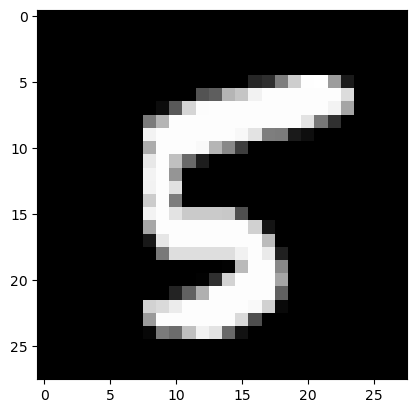

28989
Label: 4
Prediction  7
False


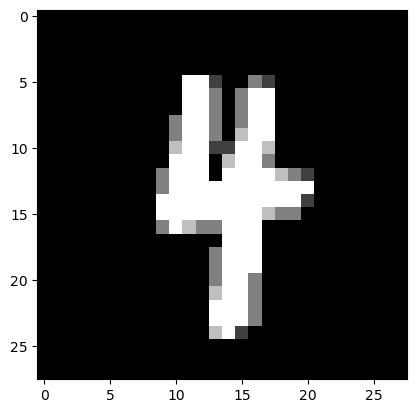

3838
Label: 5
Prediction  7
False


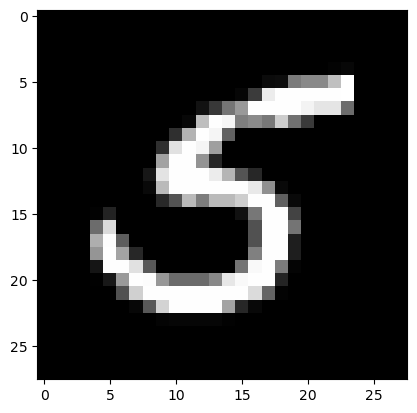

17894
Label: 3
Prediction  7
False


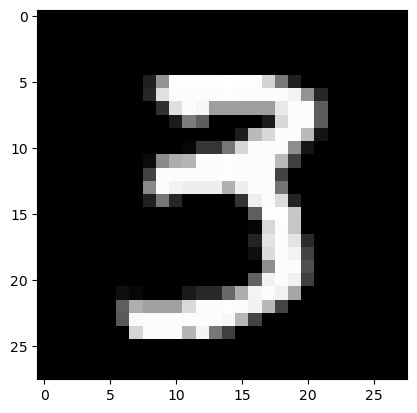

5724
Label: 0
Prediction  7
False


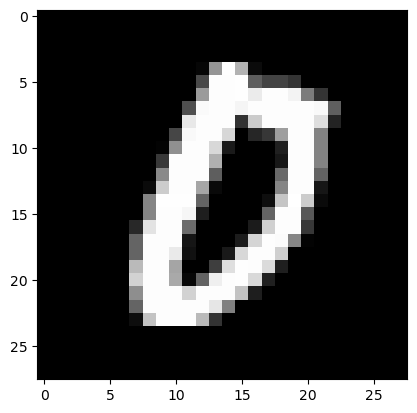

17493
Label: 7
Prediction  7
True


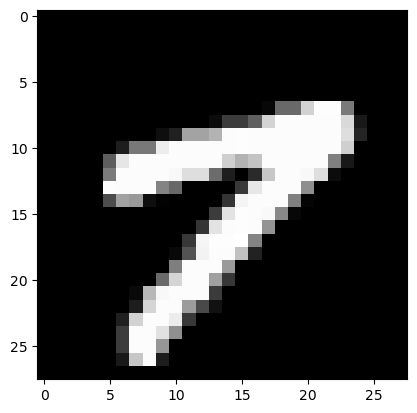

37019
Label: 1
Prediction  7
False


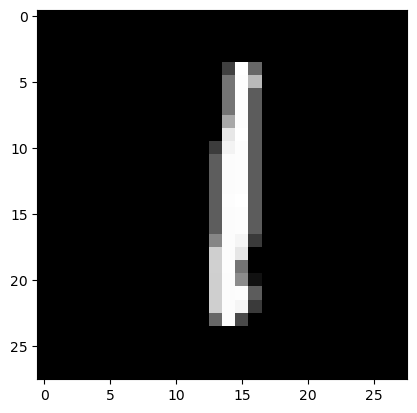

29914
Label: 4
Prediction  7
False


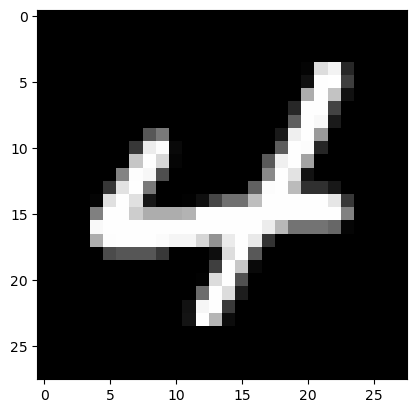

13164
Label: 4
Prediction  7
False


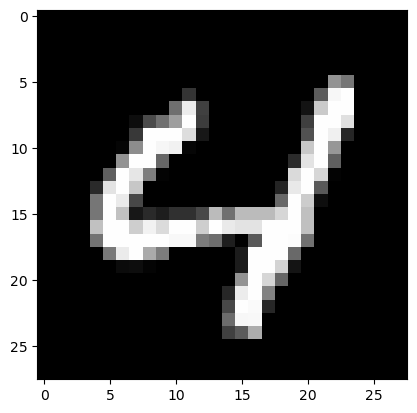

40812
Label: 7
Prediction  7
True


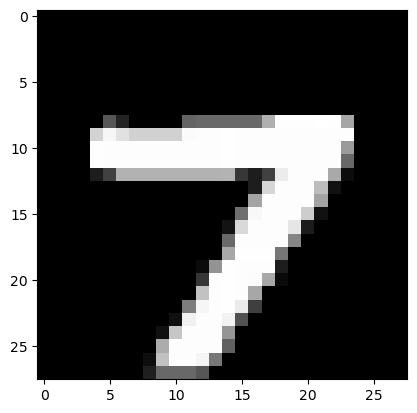

26237
Label: 7
Prediction  7
True


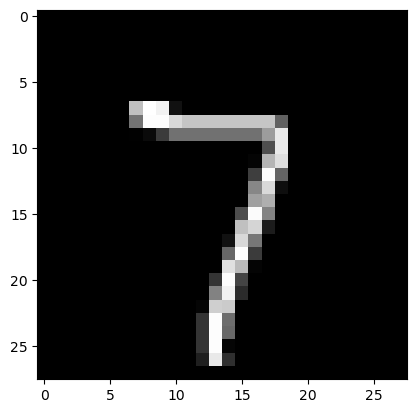

6228
Label: 5
Prediction  7
False


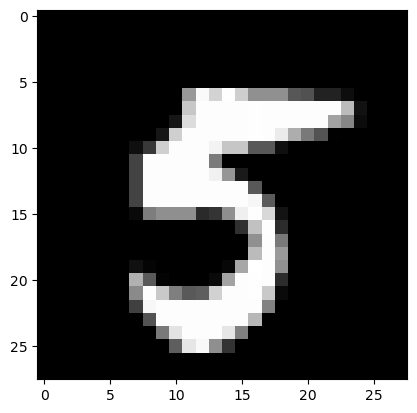

28545
Label: 7
Prediction  7
True


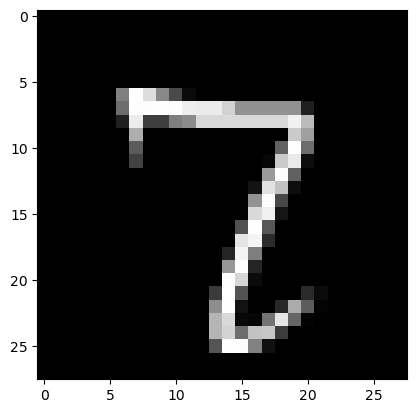

30750
Label: 6
Prediction  7
False


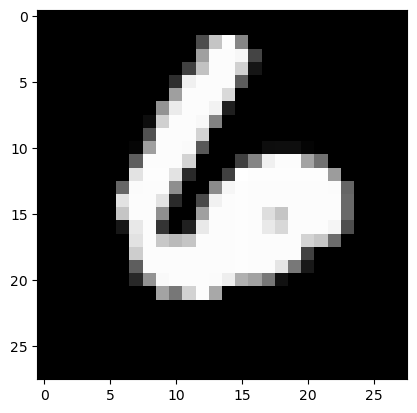

22564

In [26]:
# print(X[:,0])

for i in range(0,14):
    index = np.random.randint(0,42000)
    
    print(index)
    test_prediction(index,w1,b1,w2,b2)
#     print(index == test_prediction(index,w1,b1,w2,b2))
    
# #     test_prediction(i,w1,b1,w2,b2)
# test_prediction(1000,w1,b1,w2,b2)

###very strange - why does it not give only 1 value? now I don't know what the accuracy is even checking 
np.random.randint(5000,50000)


##### NEW ISSUE: 
#it is just not as accurate as it should be 

In [11]:
# w1